<a href="https://colab.research.google.com/github/LinasEin/pytorch-notebooks/blob/main/gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision.transforms as ToTensor
from torch.utils.data import random_split
from torchvision.utils import make_grid
import opendatasets as od
from tqdm.notebook import tqdm
import matplotlib
import matplotlib.pyplot as plt
from torchvision.utils import save_image
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [47]:
!pip install opendatasets --upgrade --quiet


In [48]:
dataset_url = 'https://www.kaggle.com/splcher/animefacedataset'
od.download(dataset_url)

Skipping, found downloaded files in "./animefacedataset" (use force=True to force download)


In [49]:
DATA_DIR = "./animefacedataset"
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [50]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  else:
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, data, device):
    self.data = data
    self.device = device
  
  def __iter__(self):
    for el in self.data:
      yield to_device(el, device)

  def __len__(self):
    return len(self.data)

In [51]:
device = get_default_device()
train_dl = DeviceDataLoader(train_dl, device)

In [52]:
discriminator = nn.Sequential(
    # in -> 3x64x64
    # out -> 64x32x32
    nn.Conv2d(3, 64, 4, 2, 1, bias = False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),

    # out -> 128x16x16
    nn.Conv2d(64, 128, 4, 2, 1, bias = False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),

    # out -> 256x8x8
    nn.Conv2d(128, 256, 4, 2, 1, bias = False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),

    # out -> 512x4x4
    nn.Conv2d(256, 512, 4, 2, 1, bias = False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),

    # out -> 1x1x1
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid()
)


latent_size = 128
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

In [53]:
generator = to_device(generator, device)
discriminator = to_device(discriminator, device)

In [54]:
def train_discriminator(real_images, opt_d):
    opt_d.zero_grad()

    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [55]:
def train_generator(opt_g):
    opt_g.zero_grad()

    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [56]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [57]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [58]:
# Fixed latent size to see how images evolve over time
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

In [59]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            loss_g = train_generator(opt_g)
            
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        print(f"Epoch [{epoch+1}/{epochs}], loss_g: {loss_g}, loss_d: {loss_d}, real_score: {real_score}, fake_score: {fake_score}")
    
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [60]:
lr = 0.0002
epochs = 25

losses_g, losses_d, real_scores, fake_scores = fit(epochs, lr)

  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [1/25], loss_g: 3.725787878036499, loss_d: 0.6831203103065491, real_score: 0.6090041399002075, fake_score: 0.07793104648590088
Saving generated-images-0001.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [2/25], loss_g: 2.8583648204803467, loss_d: 0.3797566294670105, real_score: 0.8629201054573059, fake_score: 0.17456915974617004
Saving generated-images-0002.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [3/25], loss_g: 6.070342063903809, loss_d: 0.61418616771698, real_score: 0.9185789227485657, fake_score: 0.37870657444000244
Saving generated-images-0003.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [4/25], loss_g: 3.710211753845215, loss_d: 0.5194715261459351, real_score: 0.6664946675300598, fake_score: 0.030748754739761353
Saving generated-images-0004.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [5/25], loss_g: 4.811042785644531, loss_d: 0.33853840827941895, real_score: 0.8751313090324402, fake_score: 0.16560254991054535
Saving generated-images-0005.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [6/25], loss_g: 7.351799964904785, loss_d: 0.32760319113731384, real_score: 0.7979792952537537, fake_score: 0.005989210680127144
Saving generated-images-0006.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [7/25], loss_g: 9.35108757019043, loss_d: 0.6354935169219971, real_score: 0.9954482316970825, fake_score: 0.40721333026885986
Saving generated-images-0007.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [8/25], loss_g: 3.2715251445770264, loss_d: 0.19952093064785004, real_score: 0.8873839974403381, fake_score: 0.05507660657167435
Saving generated-images-0008.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [9/25], loss_g: 4.155163288116455, loss_d: 0.13908588886260986, real_score: 0.9696893095970154, fake_score: 0.09531992673873901
Saving generated-images-0009.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [10/25], loss_g: 1.7875657081604004, loss_d: 0.41101735830307007, real_score: 0.7214125990867615, fake_score: 0.024775926023721695
Saving generated-images-0010.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [11/25], loss_g: 3.954334259033203, loss_d: 0.2143983244895935, real_score: 0.8592116832733154, fake_score: 0.029611242935061455
Saving generated-images-0011.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [12/25], loss_g: 2.34089994430542, loss_d: 2.1406264305114746, real_score: 0.19319938123226166, fake_score: 0.00013781993766315281
Saving generated-images-0012.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [13/25], loss_g: 2.7085578441619873, loss_d: 0.18974891304969788, real_score: 0.9009197354316711, fake_score: 0.06776872277259827
Saving generated-images-0013.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [14/25], loss_g: 5.533760070800781, loss_d: 0.33300063014030457, real_score: 0.9327924847602844, fake_score: 0.1958339810371399
Saving generated-images-0014.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [15/25], loss_g: 3.9325504302978516, loss_d: 0.23683786392211914, real_score: 0.896343469619751, fake_score: 0.09947546571493149
Saving generated-images-0015.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [16/25], loss_g: 4.109577655792236, loss_d: 0.4013567864894867, real_score: 0.7244279980659485, fake_score: 0.010294340550899506
Saving generated-images-0016.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [17/25], loss_g: 8.540506362915039, loss_d: 1.3535503149032593, real_score: 0.998751163482666, fake_score: 0.663937509059906
Saving generated-images-0017.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [18/25], loss_g: 4.319695949554443, loss_d: 0.1103452816605568, real_score: 0.9776856303215027, fake_score: 0.07961191236972809
Saving generated-images-0018.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [19/25], loss_g: 3.639697313308716, loss_d: 0.3813651502132416, real_score: 0.7268983125686646, fake_score: 0.010012212209403515
Saving generated-images-0019.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [20/25], loss_g: 3.792179584503174, loss_d: 0.10664422810077667, real_score: 0.9316950440406799, fake_score: 0.02994891256093979
Saving generated-images-0020.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [21/25], loss_g: 3.509146213531494, loss_d: 0.09694845229387283, real_score: 0.9322360157966614, fake_score: 0.022647248581051826
Saving generated-images-0021.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [22/25], loss_g: 1.4575592279434204, loss_d: 0.29636168479919434, real_score: 0.7984068989753723, fake_score: 0.028125744313001633
Saving generated-images-0022.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [23/25], loss_g: 4.2741498947143555, loss_d: 0.08507923036813736, real_score: 0.9665594696998596, fake_score: 0.044844917953014374
Saving generated-images-0023.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [24/25], loss_g: 5.561038017272949, loss_d: 0.12613654136657715, real_score: 0.9637911915779114, fake_score: 0.07628733664751053
Saving generated-images-0024.png


  0%|          | 0/497 [00:00<?, ?it/s]

Epoch [25/25], loss_g: 4.59694766998291, loss_d: 0.09325288236141205, real_score: 0.9585667252540588, fake_score: 0.044904716312885284
Saving generated-images-0025.png


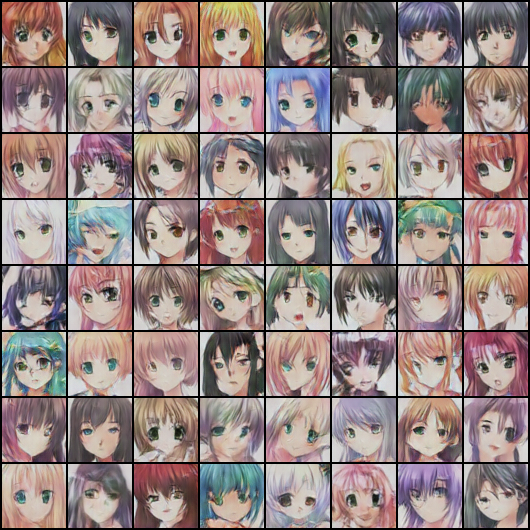

In [61]:
from IPython.display import Image
Image('./generated/generated-images-0001.png')
Image('./generated/generated-images-0025.png')

In [65]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

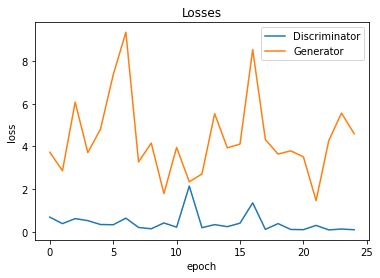

In [63]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

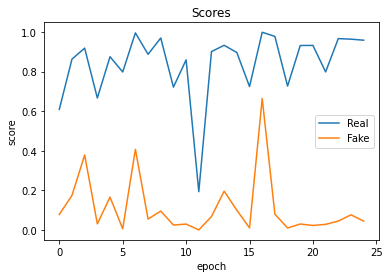

In [64]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');